# Imports

In [1]:
import pandas as pd, matplotlib.pyplot as plt, gzip, json, os, string, nltk, joblib, pickle, tarfile, shutil
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
from top2vec import Top2Vec
from huggingface_hub import login, logout, hf_hub_download, HfApi, CommitOperationAdd
from dotenv import load_dotenv
from datasets import load_dataset

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

# Images Resolution Analysis

In [2]:
images_data = pd.read_csv('images.csv')

In [3]:
images_data.head()

,image_id,height,width,path
0,010-mllS7JL,106,106,14/14fe8812.jpg
1,01dkn0Gyx0L,122,122,da/daab0cad.jpg
2,01sUPg0387L,111,111,d2/d2daaae9.jpg
3,1168jc-5r1L,186,186,3a/3a4e88e6.jpg
4,11RUV5Fs65L,30,500,d9/d91ab9cf.jpg


In [4]:
images_data.dtypes

image_id    object
height       int64
width        int64
path        object
dtype: object

Let us filter all non-quadratic shaped images out

In [5]:
images_data[
    images_data['height'] == images_data['width']
]['height'].value_counts()

2560    45005
1000    24945
2000    16154
1500    13813
1200     7518
        ...  
1157        1
1135        1
1269        1
1717        1
1897        1
Name: height, Length: 1572, dtype: int64

Images of size 2560x2560 are the most common. What about both quadratic and rectangular images?

In [6]:
(images_data['height'].astype(str) + 'x' + images_data['width'].astype(str)).value_counts()

2200x1879    92513
2560x2560    45005
1000x1000    24945
2000x2000    16154
1500x1500    13813
             ...  
2086x1941        1
1137x2529        1
1230x754         1
883x2375         1
2372x2397        1
Length: 45719, dtype: int64

There are about 2x more images with the 2200x1879 resolution compared to the 2560x2560. However, how many various values for height and width do we have in general?

<AxesSubplot:title={'center':'Width'}, ylabel='Frequency'>

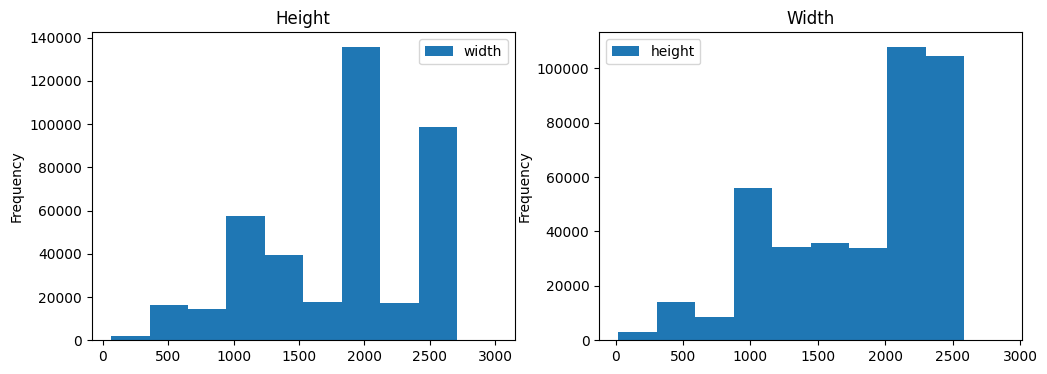

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

images_data.plot(kind='hist', x='height', ax=ax1, title='Height')
images_data.plot(kind='hist', x='width', ax=ax2, title='Width')

Evidently, we have both quite small and large images as well. Since the data is this diverse, we should decide upon a uniform resolution for our images:

1. 2200x1879 (92513 images)
2. 2560x2560 (45005 images)

In [8]:
# 2200x1879
images_2200x1879 = images_data[
    (images_data['height'] == 2200) &
    (images_data['width'] == 1879)
]

# Images Metadata Parsing

First, let us extract the category for (ideally) each image. We will create a list of dictionaries:
```
[
    {"image_id": "category},
    ...
]
```

In [9]:
gz_files = os.listdir('metadata')
gz_files = [i for i in gz_files if i != '.DS_Store']

image_metadata = []

for f in gz_files:
    with gzip.open(f'metadata/{f}', "rt", encoding='utf-8') as gz_file:
        gz_data = gz_file.read()
        gz_data_list = gz_data.split('\n')
        
        # need to parse line by line, otherwise there is an error
        for line in gz_data_list[:-1]:
            data = json.loads(line)
            try:
                image_metadata.append(
                    {
                        data['main_image_id']: [
                            data['product_type'][0]['value'],
                            data['model_name'][0]['value'],
                            data['brand'][0]['value'],
                            data['country'],
                            data['item_name'][0]['value'],
                            data['marketplace'],
                        ]
                    }
                )
                # can get more other info, see README.md for details
            except KeyError:
                pass

In [10]:
image_metadata_df = pd.DataFrame(
    {
        'image_id': [list(i.keys())[0] for i in image_metadata],
        'category': [list(i.values())[0][0] for i in image_metadata],
        'model_name': [list(i.values())[0][1] for i in image_metadata],
        'brand': [list(i.values())[0][2] for i in image_metadata],
        'country': [list(i.values())[0][3] for i in image_metadata],
        'item_name': [list(i.values())[0][4] for i in image_metadata],
        'marketplace': [list(i.values())[0][5] for i in image_metadata],
    }
)

In [11]:
image_metadata_df_2200x1879 = image_metadata_df.merge(images_2200x1879)

Let us see what categories we get for the images of size 2200x1879 px

In [12]:
image_metadata_df_2200x1879['category'].value_counts()

CELLULAR_PHONE_CASE    54815
Name: category, dtype: int64

It seems only phone cases are represented by the images of this size. Let us see what categories we have in the full dataset

In [13]:
image_metadata_df['category'].value_counts()

CELLULAR_PHONE_CASE    64559
SHOES                   7702
BOOT                    1934
SANDAL                  1784
FINERING                 578
                       ...  
EXERCISE_MAT               1
EXERCISE_BAND              1
FASTENER_DRIVE_BIT         1
AV_FURNITURE               1
UTILITY_KNIFE              1
Name: category, Length: 235, dtype: int64

All in all, phone cases is the most popular category of all the listings. I think we can reduce the problem to extracting top N similar phone cases base on the user input. Consider the following scenario:

1. A user finds a nice case on Pinterest, from a friend, etc.
2. They are obviously not sure which words to use to describe it
3. Consequently, it becomes difficult for them to buy such a case
4. As a solution, they can use our service, which will look similar cases up

The problem is quite challenging, since the model has to be able to determine all the subtle features of the case, e.g., Hello Kitty pic, stars, flowers, etc.

# First Target Variable Option – Phone Brands

Now we shall come up with a target variable for the CNN. Training the model to distinguish phone brands the cases are made for could be reasonable, since at the very least the model should recommend iphone cases when the user uploads an iphone case picture. Assuming the brand name comes first, let us try and extract the phone manufacturers names

In [14]:
image_metadata_df_2200x1879['phone_brand'] = image_metadata_df_2200x1879['model_name'].\
    str.lower().\
    str.replace('\xa0', ' ').\
    apply(lambda x: x[:x.find(' ')])

In [15]:
image_metadata_df_2200x1879['phone_brand'].value_counts()

samsung          10315
vivo              5303
oppo              3450
micromax          2830
lenovo            2805
                 ...  
gz8579-sl4042        1
gz8582-sl4077        1
gz8598-sl4076        1
gz8482-sl4080        1
gz8482-sl4054        1
Name: phone_brand, Length: 225, dtype: int64

There is a bunch of "gz" phones, we can combine them into one brand name

In [16]:
image_metadata_df_2200x1879['phone_brand'] = image_metadata_df_2200x1879['phone_brand'].str.replace(r'^gz\d{4}-sl\d{4}', 'gz', regex=True)

In [17]:
image_metadata_df_2200x1879['phone_brand'].value_counts()

samsung           10315
vivo               5303
oppo               3450
micromax           2830
lenovo             2805
apple              2761
motorola           2526
gionee             2488
lg                 2417
huawei             2098
nokia              2048
asus               1844
sony               1671
xiaomi             1444
mi                 1163
oneplus            1068
realme              955
coolpad             794
lyf                 641
lava                625
htc                 580
infocus             520
tecno               456
poco                404
panasonic           395
microsoft           336
itel                288
letv                276
moto                237
comio               213
gz                  191
leeco               184
meizu               180
i                   177
honor               168
10.or               158
karbonn             130
infinix             124
spice                99
ivoomi               90
intex                61
mobiistar       

We have already reduced the number of classes quite significantly. However, there are also 2 categories with only 1 observation. Galaxy clearly refers to Samsung, and by googling "uv10920" we can find out that it is actually a [Redmi](https://www.amazon.in/Amazon-Brand-Designer-Sparkle-Printed/dp/B085S3SBM7) smartphone case

In [18]:
image_metadata_df_2200x1879['phone_brand'] = image_metadata_df_2200x1879['phone_brand'].\
    str.replace('galaxy', 'samsung').\
    str.replace('uv10920-sl4050', 'redmi')

In [19]:
image_metadata_df_2200x1879['phone_brand'].value_counts()

samsung      10316
vivo          5303
oppo          3450
micromax      2830
lenovo        2805
apple         2761
motorola      2526
gionee        2488
lg            2417
huawei        2098
nokia         2048
asus          1844
sony          1671
xiaomi        1444
mi            1163
oneplus       1068
realme         955
coolpad        794
lyf            641
lava           625
htc            580
infocus        520
tecno          456
poco           404
panasonic      395
microsoft      336
itel           288
letv           276
moto           237
comio          213
gz             191
leeco          184
meizu          180
i              177
honor          168
10.or          158
karbonn        130
infinix        124
spice           99
ivoomi          90
intex           61
mobiistar       55
nexus           51
ikall           46
redmi           45
techno          42
lephone         30
acer            17
fluo            15
Name: phone_brand, dtype: int64

In [20]:
image_metadata_df_2200x1879['phone_brand'].value_counts().shape

(49,)

All in all, we end up with 49 unique brands in total. We can either set a threshold and combine some underrepresented classes into one category, or proceed with 49 classes. Yet, it does not seem to be the best option for a target variable as classes are extremely unbalanced

# Second Target Variable Option – BERTopic

The idea is to apply topic modelling on descriptions of phonecases and unite similarly described ones under a common topic or, alternatively, cluster

Check if all item names are written in Latin characters

In [21]:
def is_latin(s):
    s = s.replace('\xa0', ' ')
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

image_metadata_df_2200x1879[~image_metadata_df_2200x1879['item_name'].apply(is_latin)].shape

(11, 11)

11 item names contain non-Latin characters, therefore, should be dropped due to incompatibility with majority of data

In [22]:
image_metadata_df_2200x1879 = image_metadata_df_2200x1879[image_metadata_df_2200x1879['item_name'].apply(is_latin)]

Compute all words combinations in an item name column to detect possible repeated patterns

In [23]:
from collections import Counter

word_counts = Counter()
image_metadata_df_2200x1879['item_name'].str.split().apply(word_counts.update)

# Sort by count
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [24]:
repeated = []
for word, count in sorted_word_counts:
    if count >= image_metadata_df_2200x1879.shape[0]:
        print(word, count)
        repeated.append(word)

for 54872
Amazon 54804
Brand 54804
- 54804
Solimo 54804
Designer 54804
Printed 54804
Back 54804
Case 54804
Mobile 54804
Cover 54804


These words occur for every brand, therefore should be dropped for the sake of more accurate word vector representations

This step will be performed after initial preprocessing

In [25]:
# remove model names
image_metadata_df_2200x1879['item_name_tokenized'] = image_metadata_df_2200x1879.apply(
    lambda x: x['item_name'].replace(x['model_name'], ''),
    axis=1
)

In [26]:
# remove punctuation and special characters
image_metadata_df_2200x1879['item_name_tokenized'] = image_metadata_df_2200x1879['item_name_tokenized'].apply(
    lambda x: ''.join([char for char in x if char not in string.punctuation])
)

In [27]:
nltk.download('punkt')
# tokenize descriptions
image_metadata_df_2200x1879['item_name_tokenized'] = image_metadata_df_2200x1879['item_name_tokenized'].apply(
    lambda x: word_tokenize(x)
)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fedorturchenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
# now we can remove repeated phrase from each item name
image_metadata_df_2200x1879['item_name_tokenized'] = image_metadata_df_2200x1879['item_name_tokenized'].apply(
    lambda x: list(
        set(x).difference(set(repeated))
    )
)

In [29]:
# LOAD MODEL FROM HGF (do not waste time)

##---DO NOT RUN---##
# topic_model = BERTopic(nr_topics=30)
# corpus = [' '.join(i) for i in image_metadata_df_2200x1879['item_name_tokenized']]
# topics, probs = topic_model.fit_transform(corpus)
##----------------##

## load credentials
load_dotenv()
HGF_TOKEN = os.getenv('HUGGINGFACE_TOKEN')
HGF_MODEL_REPO = os.getenv('HUGGINGFACE_TOPIC_MODEL_REPO')

##---DO NOT RUN---##
## save model
# login(token=HGF_TOKEN)
# topic_model.push_to_hf_hub(
#     repo_id=HGF_MODEL_REPO
# )
# logout()
##----------------##

login(token=HGF_TOKEN)
topic_model = BERTopic.load(HGF_MODEL_REPO)
logout()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.


In [30]:
topic_model_df = topic_model.get_topic_info().set_index('Topic')
topic_model_df

,Count,Name,Representation,Representative_Docs
Topic,,,,
-1,983,-1_iphone_apple_logo_cut,"[iphone, apple, logo, cut, xs, max, with, plus...",NaN
0,11157,0_uv_soft_flowers_dark,"[uv, soft, flowers, dark, photography, love, w...",NaN
1,11134,1_vector_3d_hard_girl,"[vector, 3d, hard, girl, lady, number, daddys,...",NaN
2,9453,2_texture_color_paint_multicolor,"[texture, color, paint, multicolor, canvas, ha...",NaN
3,5756,3_flower_rangoli_stars_hard,"[flower, rangoli, stars, hard, 3d, white, pink...",NaN
4,3520,4_pattern_print_shoes_boy,"[pattern, print, shoes, boy, cloth, impression...",NaN
5,2108,5_wooden_tree_leaf_door,"[wooden, tree, leaf, door, old, leafs, block, ...",NaN
6,1681,6_photography_view_sun_moon,"[photography, view, sun, moon, solar, system, ...",NaN
7,1473,7_logo_iphone_cut_apple,"[logo, iphone, cut, apple, plus, moto, motorol...",NaN


Topic index `-1` reflects the outliers, i.e., phones for which the item name does not contain any representative information

These models will be dropped from the dataset

In [31]:
corpus = [' '.join(i) for i in image_metadata_df_2200x1879['item_name_tokenized']]
topic_df = topic_model.get_document_info(corpus)
topic_df.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,Sperking Stars Soft UV,0,0_uv_soft_flowers_dark,"[uv, soft, flowers, dark, photography, love, w...",NaN,uv - soft - flowers - dark - photography - lov...,False
1,Rangoli 3D Peacock White Hard,2,2_texture_color_paint_multicolor,"[texture, color, paint, multicolor, canvas, ha...",NaN,texture - color - paint - multicolor - canvas ...,False
2,Valley Hard 3D View,4,4_pattern_print_shoes_boy,"[pattern, print, shoes, boy, cloth, impression...",NaN,pattern - print - shoes - boy - cloth - impres...,False
3,Makeup 3D Hard Set,2,2_texture_color_paint_multicolor,"[texture, color, paint, multicolor, canvas, ha...",NaN,texture - color - paint - multicolor - canvas ...,False
4,3D Lighting Hard,1,1_vector_3d_hard_girl,"[vector, 3d, hard, girl, lady, number, daddys,...",NaN,vector - 3d - hard - girl - lady - number - da...,False


In [32]:
image_metadata_df_2200x1879['item_name_processed'] = image_metadata_df_2200x1879['item_name_tokenized'].apply(' '.join)
training_data = pd.concat(
    [
        image_metadata_df_2200x1879[['path', 'item_name_processed']].reset_index(drop=True),
        topic_df.rename(
            {
                'Topic': 'topic',
                'Name': 'topic_name'
            },
            axis=1
        )[['topic', 'topic_name']]
    ],
    axis=1
)

In [33]:
training_data = training_data.query('topic != -1') # remove "outliers"
training_data.head()

,path,item_name_processed,topic,topic_name
0,02/0257d665.jpg,Sperking Stars Soft UV,0,0_uv_soft_flowers_dark
1,ff/fff5daaa.jpg,Rangoli 3D Peacock White Hard,2,2_texture_color_paint_multicolor
2,e2/e29e0326.jpg,Valley Hard 3D View,4,4_pattern_print_shoes_boy
3,a5/a56285ef.jpg,Makeup 3D Hard Set,2,2_texture_color_paint_multicolor
4,a3/a378a264.jpg,3D Lighting Hard,1,1_vector_3d_hard_girl


We managed to extract topics and their corresponding meaningful interpretations, reducing the total number of classes from 49 to 29. Even though imbalanced classes problem was diminished, yet still there are certain ones with extremely low number of observations

# Third Target Variable Option – Top2Vec

Since BERTopic did not produce favorable outcome, let us use another embedding-based topic modelling library to try and obtain better descriptions clusters. It uses sentence-level embeddings rather than word-level ones which may result in better performance

In [34]:
# LOAD MODEL FROM HGF (do not waste time)

##---DO NOT RUN---##
# docs = image_metadata_df_2200x1879.drop_duplicates(['path'])['item_name']
# docs_ids = image_metadata_df_2200x1879.drop_duplicates(['path'])['image_id'].values
# topic_model = Top2Vec(docs.values, embedding_model='distiluse-base-multilingual-cased', document_ids=docs_ids)
##----------------##

HGF_MODEL_TOP2VEC_REPO = os.getenv('HUGGINGFACE_TOPIC_MODEL_TOP2VEC_REPO')
HGF_MODEL_TOP2VEC_FILE = os.getenv('HUGGINGFACE_TOPIC_MODEL_TOP2VEC_FILE')

##---DO NOT RUN---##
## save model
# filename = 'top2vec_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(topic_model, file)

# login(token=HGF_TOKEN)
# api = HfApi()
# operations = [
#     CommitOperationAdd(path_in_repo=filename, path_or_fileobj=filename),
# ]
# api.create_commit(
#     repo_id=HGF_MODEL_TOP2VEC_REPO,
#     operations=operations,
#     commit_message='upload model',
# )
# logout()
# # no need to keep it on local any further
# os.remove(filename)
##----------------##

topic_model_file = hf_hub_download(repo_id=HGF_MODEL_TOP2VEC_REPO, filename=HGF_MODEL_TOP2VEC_FILE, token=HGF_TOKEN)
with open(topic_model_file, 'rb') as file:
    topic_model = pickle.load(file)

In [35]:
N_TOPICS = topic_model.get_num_topics()
print(f'Total topics identified: {N_TOPICS}')

Total topics identified: 57


Extract topics representations

In [36]:
topic_words, word_scores, topic_nums = topic_model.get_topics(N_TOPICS)

Perform mapping of topics onto original data

In [37]:
topic_sizes, topic_nums = topic_model.get_topic_sizes()
images_ids = []
images_topics = []

for size, topic in zip(topic_sizes, topic_nums):
    documents, document_scores, document_ids = topic_model.search_documents_by_topic(topic_num=topic, num_docs=size)
    images_ids.append(document_ids)
    images_topics.append(topic)

In [38]:
topics_df = pd.DataFrame({'image_id': images_ids, 'topic': images_topics})
topics_df = topics_df.explode('image_id')
print(topics_df.shape)
topics_df = pd.merge(
    topics_df,
    pd.DataFrame({'topic': topic_nums, 'representation': list(map(' '.join, topic_words))}),
    how='left',
    on='topic'
)
print(topics_df.shape)
topics_df.head()

(54652, 2)
(54652, 3)


,image_id,topic,representation
0,71TQQO0+jfL,0,cover mobile design case printed designer prin...
1,61PzHx1mWjL,0,cover mobile design case printed designer prin...
2,71yvuBYvLAL,0,cover mobile design case printed designer prin...
3,71w5gFk8h2L,0,cover mobile design case printed designer prin...
4,71Aqty5d1jL,0,cover mobile design case printed designer prin...


In [39]:
training_data = pd.merge(
    image_metadata_df_2200x1879,
    topics_df,
    how='left',
    on='image_id'
)

In [40]:
print(training_data.shape)
training_data.head()

(54804, 15)


,image_id,category,model_name,brand,country,item_name,marketplace,height,width,path,phone_brand,item_name_tokenized,item_name_processed,topic,representation
0,61PjvipfNfL,CELLULAR_PHONE_CASE,Itel A25,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Sperking Stars ...,Amazon,2200,1879,02/0257d665.jpg,itel,"[Sperking, Stars, Soft, UV]",Sperking Stars Soft UV,38,cover printed mobile sunside print cotton shad...
1,81zNMSIDRRL,CELLULAR_PHONE_CASE,Asus Zenfone 3 Laser ZC551KL,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer White Peacock R...,Amazon,2200,1879,ff/fff5daaa.jpg,asus,"[Rangoli, 3D, Peacock, White, Hard]",Rangoli 3D Peacock White Hard,3,cover design max case zenfone designer printed...
2,710EXpQig4L,CELLULAR_PHONE_CASE,Vivo Y69,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Valley View 3D ...,Amazon,2200,1879,e2/e29e0326.jpg,vivo,"[Valley, Hard, 3D, View]",Valley Hard 3D View,0,cover mobile design case printed designer prin...
3,71wFnGN0FwL,CELLULAR_PHONE_CASE,Motorola Moto E 2nd Generation,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Makeup Set 3D P...,Amazon,2200,1879,a5/a56285ef.jpg,motorola,"[Makeup, 3D, Hard, Set]",Makeup 3D Hard Set,4,mobile motorola motorcycle design cover moto c...
4,71aFO7Pla1L,CELLULAR_PHONE_CASE,Vivo V9 / V9 Pro,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Lighting 3D Pri...,Amazon,2200,1879,a3/a378a264.jpg,vivo,"[3D, Lighting, Hard]",3D Lighting Hard,0,cover mobile design case printed designer prin...


In [41]:
training_data['topic'].value_counts()

0     24840
1      2428
2      2344
3      2066
4      2059
5      1547
6      1292
7      1037
8       893
9       877
10      741
11      731
12      723
13      718
14      635
15      627
16      598
17      579
18      541
19      517
20      505
21      470
22      440
23      430
24      405
25      387
26      381
27      378
28      376
30      370
29      368
31      367
32      329
33      318
34      281
35      276
36      275
37      272
38      251
39      250
40      191
41      179
42      173
43      168
44      153
45      141
46      136
47      126
48      117
49       81
50       80
51       77
52       62
53       62
54       60
55       55
56       21
Name: topic, dtype: int64

Imbalance issue has not been solved even in top2vec case. However, it produced a lot of classes, majority of which are close in number of observations

# Generate and upload image dataset to HuggingFace

`abo-images-small.tar` in the repository is a dummy one

It does not contain any images and is present only for understanding of where it should be located respective to this notebook

Replace it with a real file, downloaded from https://amazon-berkeley-objects.s3.amazonaws.com/index.html, only in case you want to run the below code

ALL THESE ACTIONS ARE ALREADY PERFROMED – DO NOT RUN

In [42]:
# # unzip only required files
# with tarfile.open('abo-images-small.tar', 'r') as tar:
#     for image in training_data['path']:
#         image_to_extract = tar.getmember(f'images/small/{image}')
#         tar.extract(member=image_to_extract)

In [43]:
# # generate huggingface `'imagefolder'` structure of directories
# for name in training_data['topic'].unique():
#     os.mkdir(f'images/{name}')

In [44]:
# # move files from directory to which they were unzipped
# # to the newly created `'imagefolder'` structure of directories
# for dir in os.listdir('images/small/'):
#     for file in os.listdir(f'images/small/{dir}'):
#         dest_folder = 'images/'+training_data[training_data['path']==f'{dir}/{file}']['topic'].astype(str).values[0]
#         shutil.move(f'images/small/{dir}/{file}', dest_folder)

In [45]:
# # remove directory where the images were unzipped for correct huggingface dataset creation
# shutil.rmtree('images/small')

In [46]:
# upload dataset to huggingface
# dataset = load_dataset('imagefolder', data_dir='images', split='train')
# dataset = dataset.train_test_split(test_size=0.25, shuffle=True, seed=42)
# dataset.push_to_hub('ucy-dl-cloud/ucy_dl_dataset_top2vec_labels', private=True, token=HGF_TOKEN)